# Basic Conditional GAN (Using Mnist image data)
 **Hung-yi Lee Video:  
 https://www.youtube.com/watch?v=LpyL4nZSuqU&feature=youtu.be

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Read mnist data
**Download 'mnist.npz' from: https://s3.amazonaws.com/img-datasets/mnist.npz

** Or using coding below :      
import tensorflow as tf      
mnist = tf.keras.datasets.mnist     
(x_train, y_train),(x_test, y_test) = mnist.load_data()     
x_train, x_test = x_train / 255.0, x_test / 255.0   


In [2]:
def one_hot(data):
    '''Label convert to onehot!!'''
    one_hot = np.zeros((data.shape[0], 10))
    one_hot[np.arange(data.shape[0]), data] = 1
    return one_hot

In [3]:
mnist_data = np.load('mnist.npz')

x_test = mnist_data['x_test'].reshape((-1, 784)) 
x_train = mnist_data['x_train'].reshape((-1, 784))
y_train = one_hot(mnist_data['y_train'])
y_test = one_hot(mnist_data['y_test'])


x_train, x_test = x_train / 255.0, x_test / 255.0
mb_size = 60
Z_dim = 784
X_dim = x_train.shape[1]
y_dim = y_train.shape[1]
h_dim = 128

In [4]:
# check data shape
print("X_train data shape: ", x_train.shape)
print("y_train data shape: ", y_train.shape)
print("X_test data shape: ", x_test.shape)
print("y_test data shape: ", y_test.shape)

X_train data shape:  (60000, 784)
y_train data shape:  (60000, 10)
X_test data shape:  (10000, 784)
y_test data shape:  (10000, 10)


# Function to show imagine

In [5]:
def plot(samples):
    '''Function to show image'''
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        #ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig

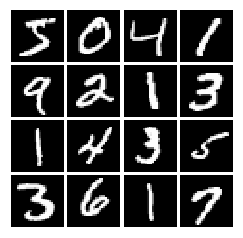

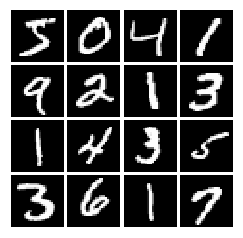

In [6]:
#Plot date
plot(x_train[0:16])

# Building Conditional GAN Model

In [7]:
def xavier_init(size):
    ''' Function for initializing the weight value by normal distribution'''
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [8]:
""" Discriminator Net model:
     - Input  : real & fake + label
     - Output : one number, mean real or fake
"""
# input:  image & label
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])


# Weights & bias of  first layer
D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))


# Weights & bias of  second layer
# output one value, mean real of fake
D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1])) 

#???
theta_D = [D_W1, D_W2, D_b1, D_b2]


def discriminator(x, y):
    ''' combine two layers !'''
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit

In [9]:
""" Generator Net model:
     - Input  : random noise vector 
     - Output : Create one image as real as possible
"""
# input: image shape
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

# Weights & bias of  first layer
G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# Weights & bias of  second layer
# output one one image
G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(z, y):
    ''' combine two layers !'''
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob

In [10]:
""" Call function to building model"""
G_sample = generator(Z, y)# model G
D_real, D_logit_real = discriminator(X, y) # model D

# G create fake image &  D day the image is real of fake
D_fake, D_logit_fake = discriminator(G_sample, y) 

# Create defect model

In [11]:
def make_defect(data):
    data_no = data.shape[0]
    for no in range(data_no):
        file = data[no].reshape(28,28)
        file[[5,8, 12,16,20,24], :] = 0.
        file[:, [5,8, 12,16,20,24]] = 0.
        data[no] = file.reshape(1, 784)
    return data

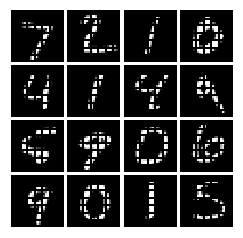

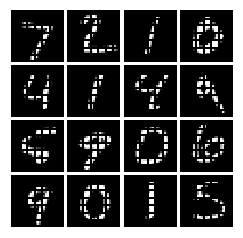

In [12]:
defect_data = make_defect(x_test[0:16])
defect_label = y_test[0:16]
plot(defect_data)

# Show model

In [13]:
def sample_Z(m, n):
    '''Function to create random noise'''
    return np.random.uniform(-1., 1., size=[m, n])


def load_model(sess, save_dir='./model_saved/', file_no=None):
    assert isinstance(file_no, int), "Input the param of file_no"
    save_path = os.path.join(save_dir,
                             str(file_no)+".npy")
    print("Loading the model from %s..." %save_path)
    data_dict = np.load(save_path).item() 
    #"np.load": Load arrays or pickled objects from .npy, .npz or pickled files.
    count = 0
    for v in tf.global_variables():
        if v.name in data_dict.keys():
            sess.run(v.assign(data_dict[v.name]))
            count += 1
    print("%d tensors loaded....." %count)
    return sess

Loading the model from ./model_saved/114000.npy...
8 tensors loaded.....


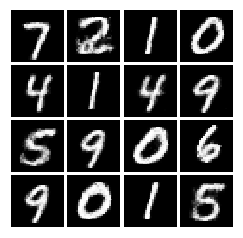

In [14]:
with tf.Session() as sess: 
    
    # Load model that already be trained
    load_model(sess, file_no=114000)
    tf.get_default_graph().finalize()
    
    n_sample = 16
    Z_sample = defect_data # random noise
    y_sample = defect_label

    # Run G & give the input
    samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

    plot(samples)
    #fig = plot(samples)
    #plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
    #plt.close(fig)
    

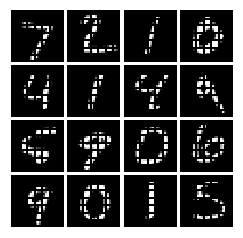

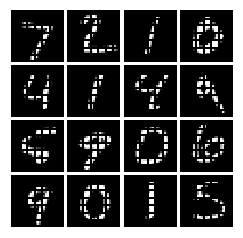

In [16]:
plot(defect_data)